# Kaggle Tabular Playground Series Air Pollution Predictions

## Import Libraries

In [37]:
!pip install catboost # CatBoost
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_log_error # error metric 
from pylab import rcParams
import statsmodels.api as sm # time series decomposition
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # time series auto/partial correlation
from statsmodels.tsa.stattools  import adfuller # stationary test
from sklearn.preprocessing import StandardScaler # scaling
from sklearn.feature_selection import mutual_info_regression # mutual information


plt.style.use("seaborn-whitegrid")
color_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', 
                 '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

import warnings  
warnings.filterwarnings('ignore')

%matplotlib inline

## Read in Data

In [38]:
# Read in data
train_path = 'train.csv'
test_path = 'test.csv'
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

frames = [train, test]
df = pd.concat(frames)

In [39]:
print("Train set: ", train.shape)
print("Test set: ", test.shape)

Train set:  (7111, 12)
Test set:  (2247, 9)


## Data Exploration

### Gain Info on Data

In [40]:
train.shape, test.shape

((7111, 12), (2247, 9))

In [41]:
train.describe()

,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
count,7111.000000,7111.000000,7111.000000,7111.000000,7111.000000,7111.000000,7111.000000,7111.000000,7111.000000,7111.000000,7111.000000
mean,20.878034,47.561004,1.110309,1091.572100,938.064970,883.903305,1513.238349,998.335565,2.086219,10.237083,204.066784
std,7.937917,17.398731,0.398950,218.537554,281.978988,310.456355,350.180310,381.537695,1.447109,7.694426,193.927723
min,1.300000,8.900000,0.198800,620.300000,364.000000,310.600000,552.900000,242.700000,0.100000,0.100000,1.900000
25%,14.900000,33.700000,0.855900,930.250000,734.900000,681.050000,1320.350000,722.850000,1.000000,4.500000,76.450000
50%,20.700000,47.300000,1.083500,1060.500000,914.200000,827.800000,1513.100000,928.700000,1.700000,8.500000,141.000000
75%,25.800000,60.800000,1.404150,1215.800000,1124.100000,1008.850000,1720.400000,1224.700000,2.800000,14.200000,260.000000
max,46.100000,90.800000,2.231000,2088.300000,2302.600000,2567.400000,2913.800000,2594.600000,12.500000,63.700000,1472.300000


In [42]:
test.describe()

,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5
count,2247.000000,2247.000000,2247.000000,2247.000000,2247.000000,2247.000000,2247.000000,2247.000000
mean,10.808144,51.031242,0.627053,1106.534490,836.459769,828.321495,1104.850601,1029.851535
std,6.444497,16.665047,0.266588,205.341455,272.816585,339.511779,293.112225,434.863287
min,-1.800000,9.800000,0.184700,665.900000,356.200000,320.100000,523.400000,218.800000
25%,5.600000,36.900000,0.413350,951.500000,640.700000,597.050000,899.450000,688.550000
50%,9.800000,50.600000,0.596400,1080.400000,800.800000,757.100000,1076.200000,973.100000
75%,14.200000,63.550000,0.804950,1222.100000,1016.100000,944.950000,1288.350000,1324.000000
max,30.900000,88.800000,1.393000,1882.900000,1776.100000,1975.000000,2211.400000,2593.800000


In [43]:
test.head()

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5
0,2011-01-01 00:00:00,8.0,41.3,0.4375,1108.8,745.7,797.1,880.0,1273.1
1,2011-01-01 01:00:00,5.1,51.7,0.4564,1249.5,864.9,687.9,972.8,1714.0
2,2011-01-01 02:00:00,5.8,51.5,0.4689,1102.6,878.0,693.7,941.9,1300.8
3,2011-01-01 03:00:00,5.0,52.3,0.4693,1139.7,916.2,725.6,1011.0,1283.0
4,2011-01-01 04:00:00,4.5,57.5,0.4650,1022.4,838.5,871.5,967.0,1142.3


In [44]:
data_types = train.dtypes.value_counts()
data_types

float64    11
object      1
dtype: int64

We have 7111 training and 2247 testing observations in float format.

### Define Data

In [45]:
# Data without time series
X = train[['deg_C', 'relative_humidity', 'absolute_humidity',
           'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5']]

y = train[['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides']]

### Visualize and Analyze Data
- Check for nulls
- Look at feature distributions
- Analyze correlations

In [46]:
# Check for nulls
df.isnull().sum()

date_time                    0
deg_C                        0
relative_humidity            0
absolute_humidity            0
sensor_1                     0
sensor_2                     0
sensor_3                     0
sensor_4                     0
sensor_5                     0
target_carbon_monoxide    2247
target_benzene            2247
target_nitrogen_oxides    2247
dtype: int64

Our data is not missing any values (there aren't any null values).

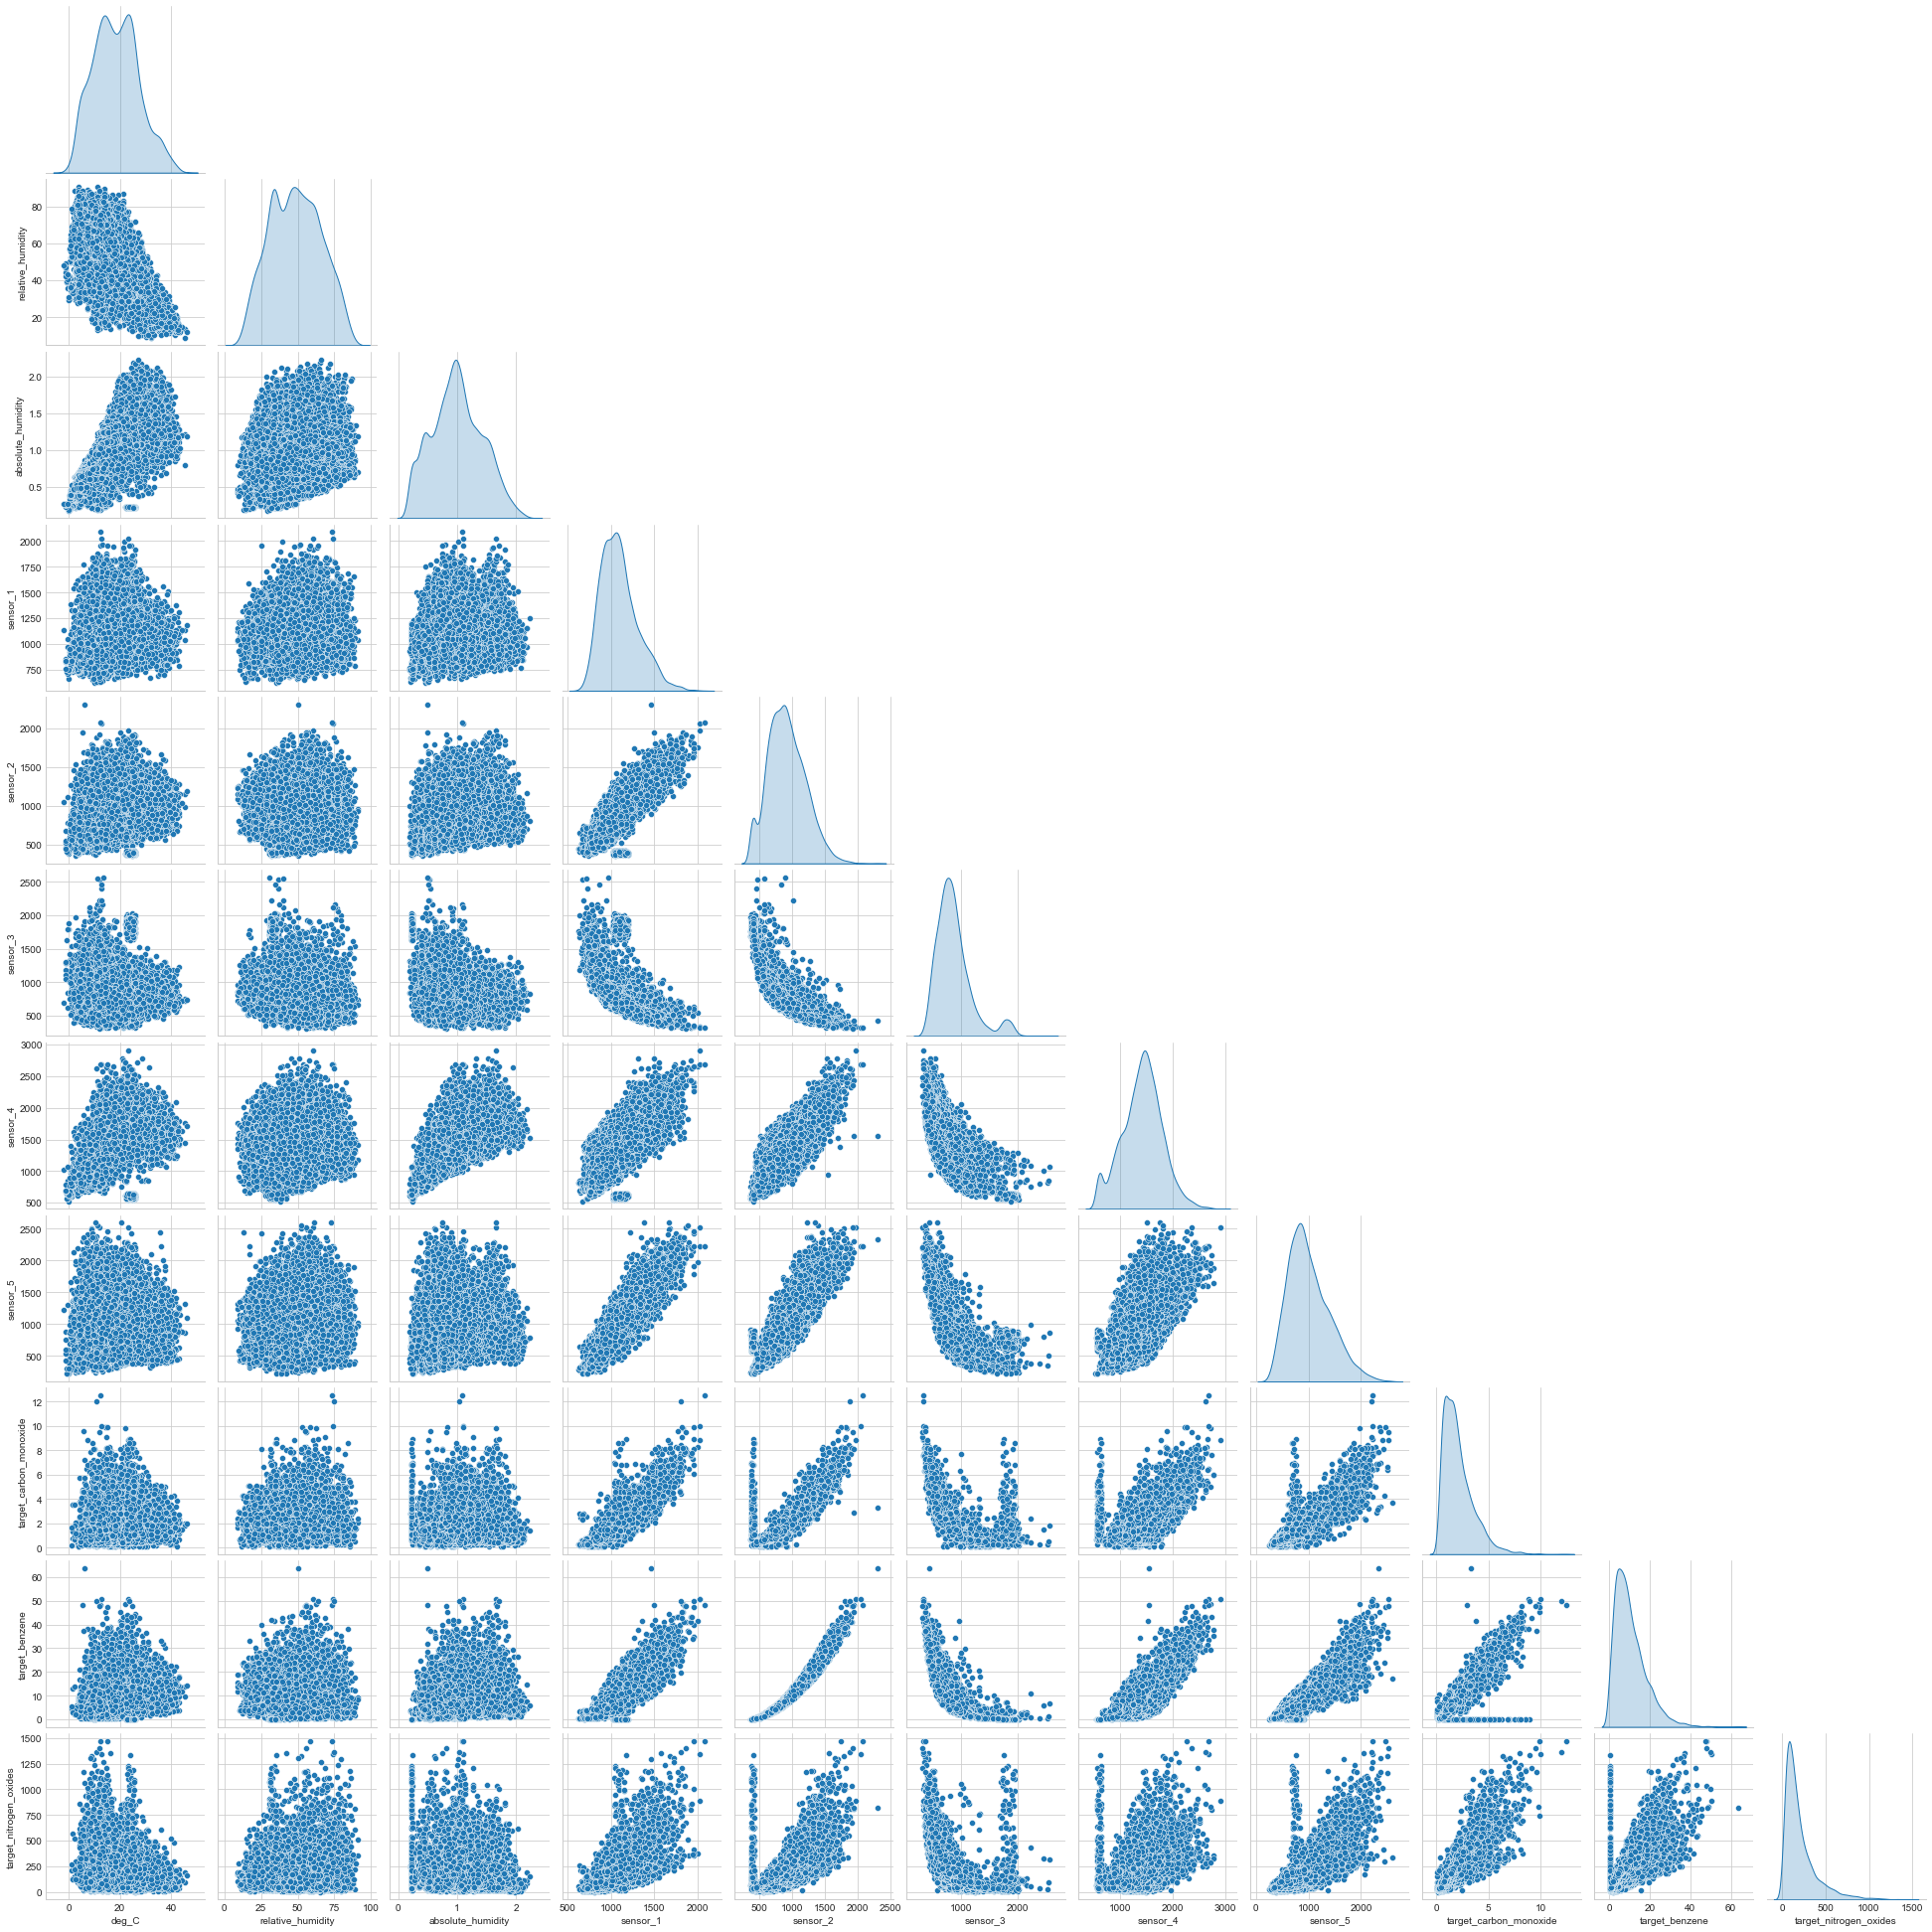

In [47]:
# Analyze distribution of each feature
sns.pairplot(data=df, diag_kind='kde', corner=True)

**What to notice about these graphs:**

- Features: sensor_1, sensor_2, sensor_3, sensor_5 are skewed

- Targets: all targets are right skewed

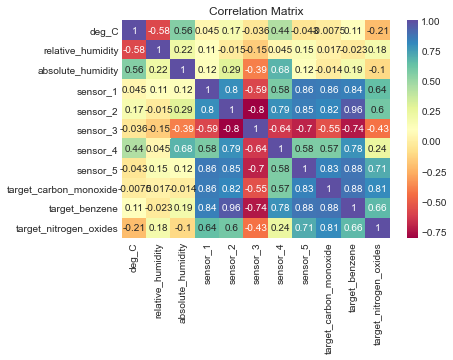

In [48]:
# Look at correlation matrix for each target
sns.heatmap(df.corr(), cmap='Spectral', annot=True)
plt.title('Correlation Matrix')
plt.show()

**What do we notice:**

- Sensors 1, 2, and 5 are moderate/strong correlated to all targets
- Sensor 3 is negatively correlated to all targets
- 'deg_C', 'relative_humidity', and 'absolute_humidity' have very weak correlations to all targets (consider dropping?)

## Time Series Decomposition

### Seasonality

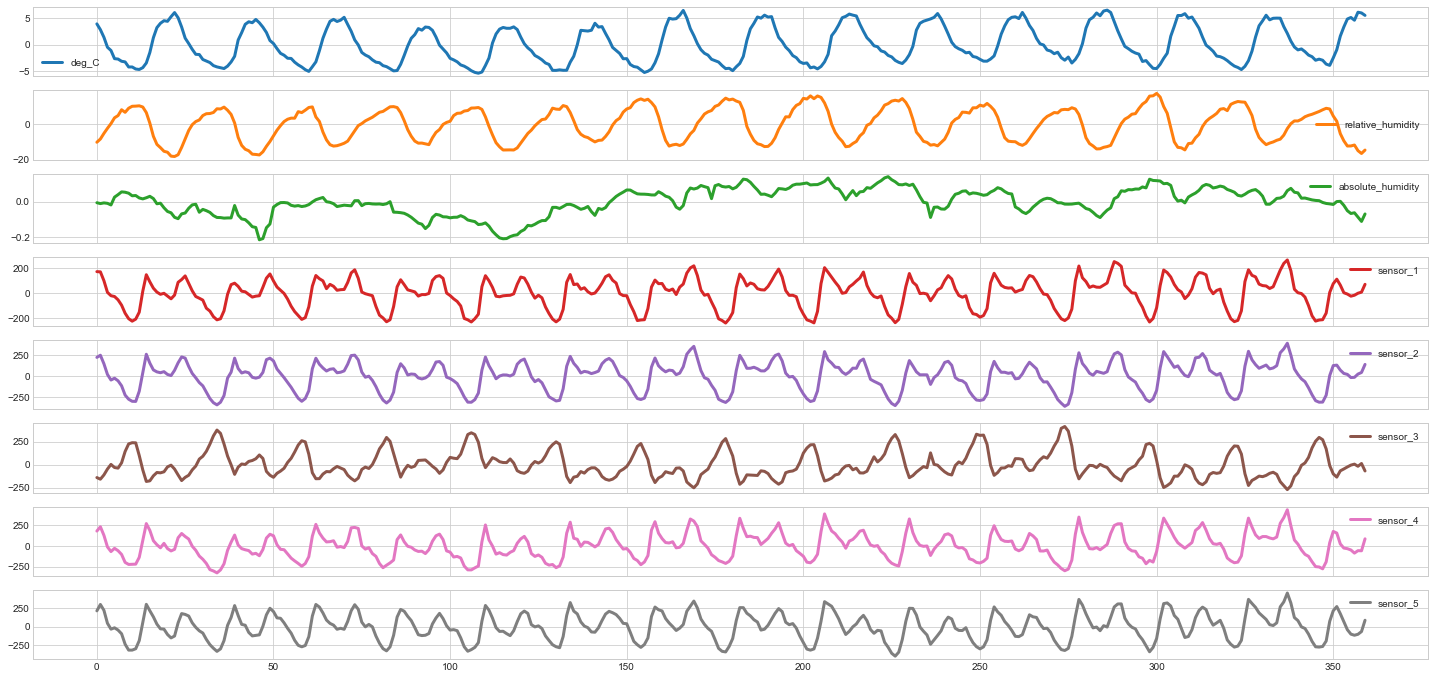

In [49]:
# Initialize empty dict to store decomposed results
seasonality_dict = {}

for feature in train.columns[1:-3]:
    decompositions = sm.tsa.seasonal_decompose(train[feature], freq=360)
    # Store results
    seasonality_dict[feature] = decompositions.seasonal
    
# Plot
rcParams['figure.figsize'] = 25, 12
pd.DataFrame(seasonality_dict)[0:360].plot(subplots=True, layout=(8,1), linewidth=3);

Most features have rather different seasonality patterns.

- sensor_1, sensor_2, sensor_4, sensor_5 have very similar seasonality patterns
- deg_C and relative_humidity have a rather ODD relationship

### Trend Analysis

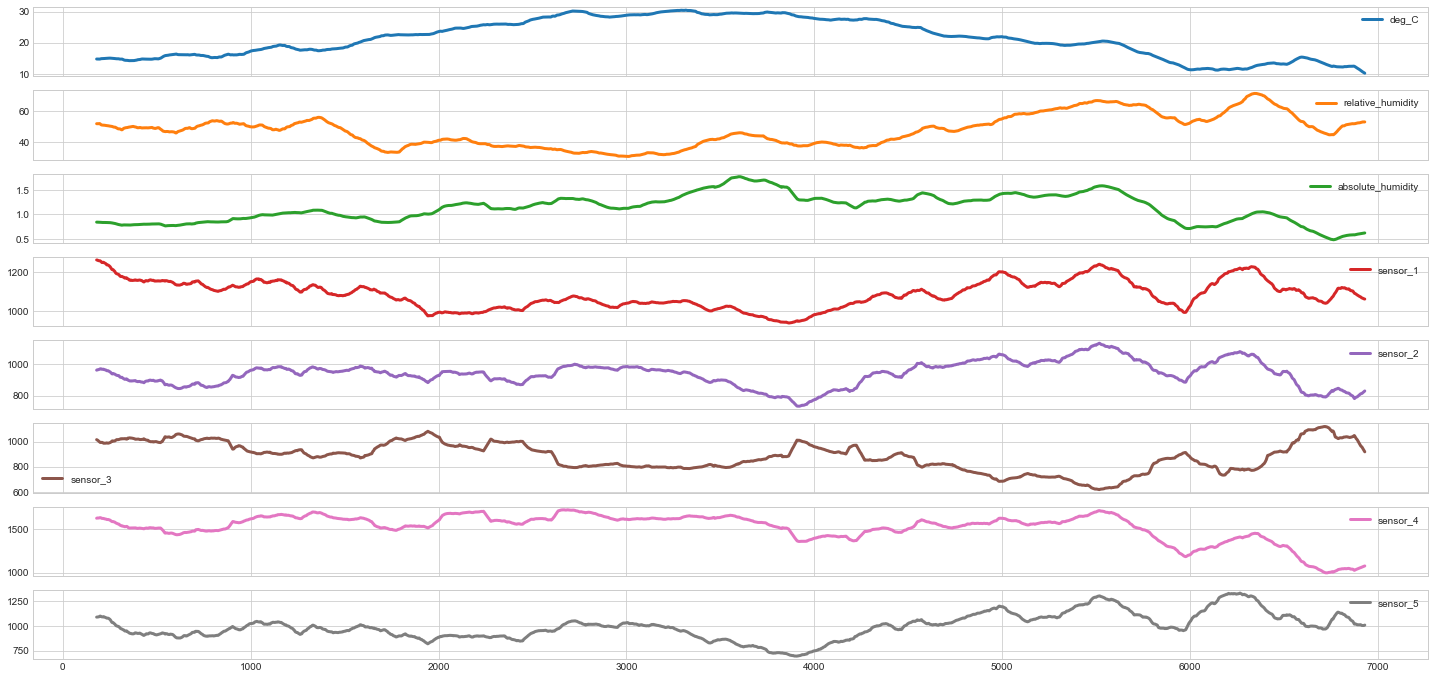

In [50]:
# Initialize empty dict to store decomposed results
trend_dict = {}

for feature in train.columns[1:9]:
    decompositions = sm.tsa.seasonal_decompose(train[feature], freq=360)
    # Store results
    trend_dict[feature] = decompositions.trend
    
# Plot
rcParams['figure.figsize'] = 25, 12
pd.DataFrame(trend_dict).plot(subplots=True, layout=(8,1), linewidth=3);

Most features have rather different trend patterns.
- sensor_1, sensor_2, sensor_4, sensor_5 have very similar trend patterns (also wtih relative_humidity)
- deg_C and sensor_3 do not share a trend relationship with any other features

### Noise (Resid)

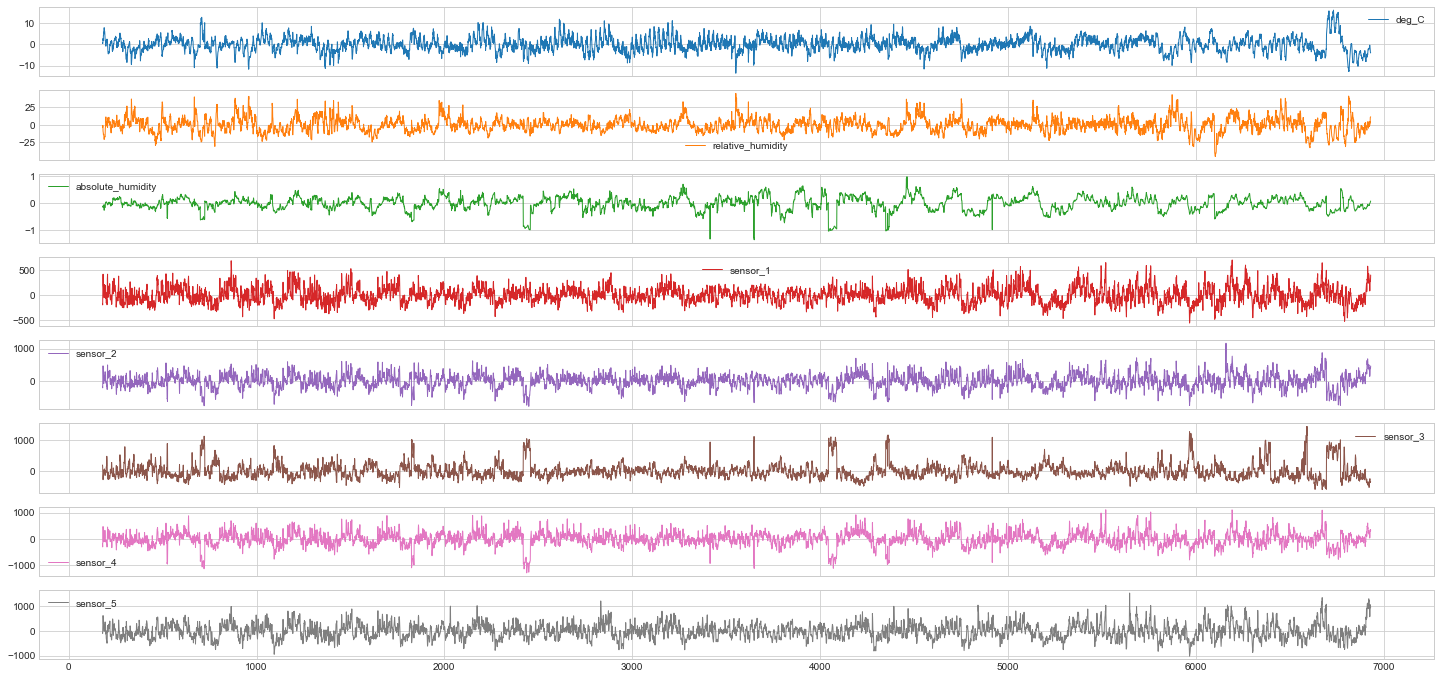

In [51]:
# Initialize empty dict to store decomposed results
resid_dict = {}

for feature in train.columns[1:9]:
    decompositions = sm.tsa.seasonal_decompose(train[feature], freq=360)
    # Store results
    resid_dict[feature] = decompositions.resid
    
# Plot
rcParams['figure.figsize'] = 25, 12
pd.DataFrame(resid_dict).plot(subplots=True, layout=(8,1), linewidth=1);

- absolute_humidity, sensor_4 (and possibly sensor_2) follow similar residual patterns
- deg_C and relative_humidity seem ODD to one another

### Augmented Dickey-Fuller Test (Stationarize Data)

ADF tests the null hypothesis that a unit root is present within the time series sample. A unit root is not present if the data is stationary, so the null hypothesis is rejected.

In [52]:
# Augmented Dickey-Fuller test on features of train set
for i in range(len(train.columns[1:9])):
    adf = adfuller(train.iloc[:, i+1])
    print("p-value of {}: {}".format(train.columns[i+1], float(adf[1])))

p-value of deg_C: 0.0065791345831177584
p-value of relative_humidity: 3.801124963247898e-08
p-value of absolute_humidity: 1.3198127519497056e-07
p-value of sensor_1: 1.4927849124692558e-12
p-value of sensor_2: 2.0508701048262788e-16
p-value of sensor_3: 1.311276892809901e-16
p-value of sensor_4: 9.263764853938977e-12
p-value of sensor_5: 1.9313270488931833e-14


All features have a p-value less than 0.05, so the null hypothesis is rejected and this is not a random walk. (All features are stationary)

In [53]:
# Augmented Dickey-Fuller test on targets of train set
for i in range(len(train.columns[9:12])):
    adf = adfuller(train.iloc[:, i+9])
    print("p-value of {}: {}".format(train.columns[i+9], float(adf[1])))

p-value of target_carbon_monoxide: 7.263413572494009e-15
p-value of target_benzene: 1.3715073973956035e-15
p-value of target_nitrogen_oxides: 8.106358998505751e-07


All targets have a p-value less than 0.05, so the null hypothesis is rejected and this is not a random walk. (All targets are stationary)

## Autocorrelation and Partial Autocorrelation 
(Data must be Stationary to draw proper conclusions)
- Autocorrelation: measures how a series is correlation with itself at different lags
- Partial Autocorrelation: regression of series against its past lags; contribution of change in particular lag while holding others constant
- For data > 240 observations, max lag = root(n) + 45 ----> roughly 128
- Use lag = 24 because of hourly data

### Autocorrelation - Use AR Model (Positive autocorrelations at lag 1)

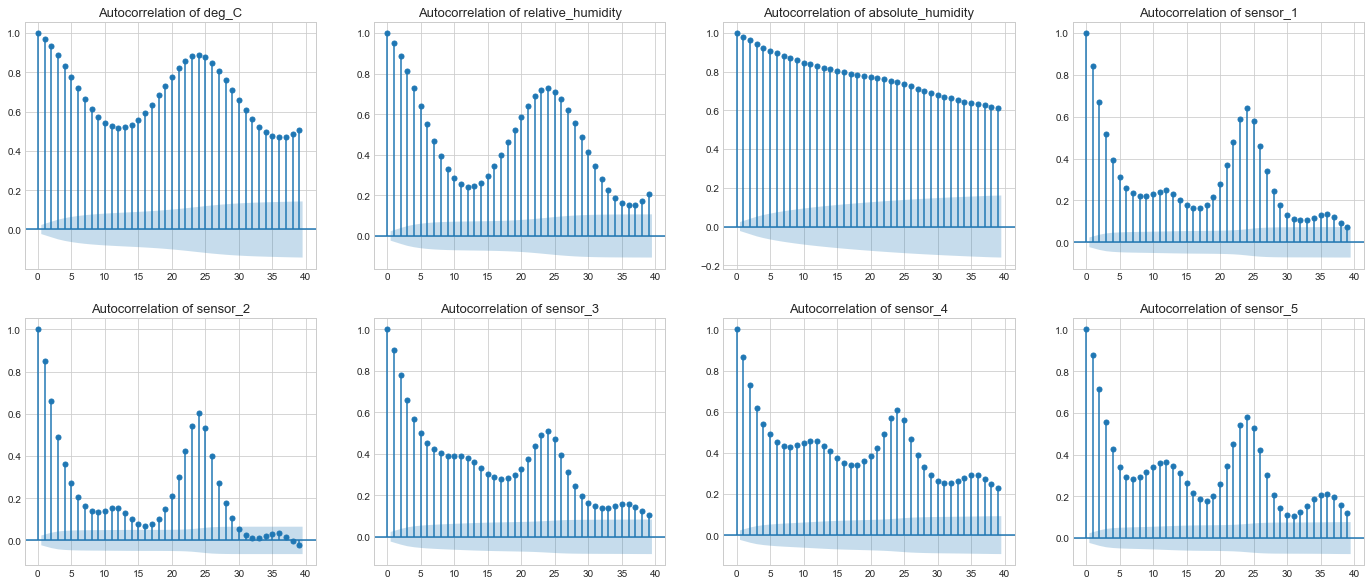

In [54]:
# Autocorrelation of all features
fig, ax = plt.subplots(2,4,figsize=(24,10))
for i in range(len(train.columns[1:9])):
    #plot_acf(train.iloc[:, i+1], lags=48, ax=ax[i//4, i%4])
    plot_acf(train.iloc[:, i+1], ax=ax[i//4, i%4])
    ax[i//4, i%4].set_title(f'Autocorrelation of {train.columns[i+1]}',fontsize=13)
plt.show()

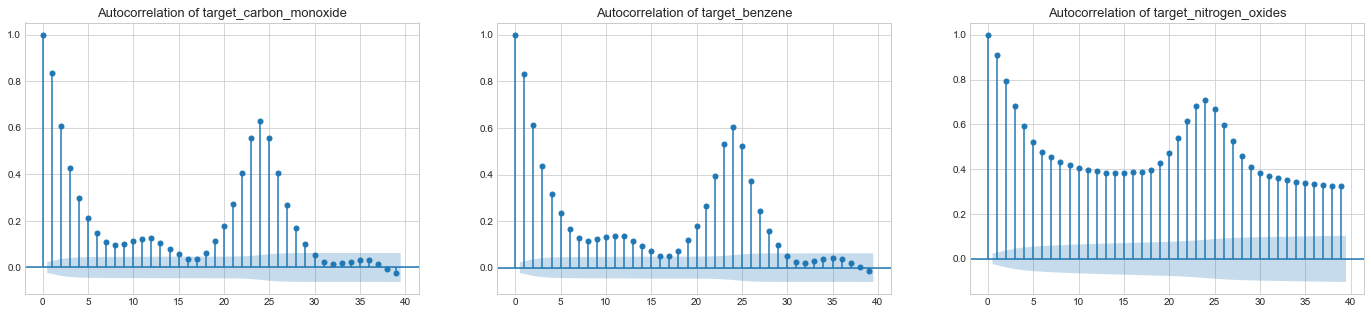

In [55]:
# Autocorrelation of all targets
fig, ax = plt.subplots(1,3,figsize=(24,5))
for i in range(len(train.columns[9:12])):
    #plot_acf(train.iloc[:, i+9], lags=48, ax=ax[i%3])
    plot_acf(train.iloc[:, i+9], ax=ax[i%3])
    ax[i%3].set_title(f'Autocorrelation of {train.columns[i+9]}',fontsize=13)
plt.show()

As all lags are either close to 1 or greater than the confidence interval, they are statistically significant.

### Partial Autocorrelation
Interpretation of Partial Autocorrelation is based on patterns to help specify the autoregressive and MA terms in an ARIMA model.

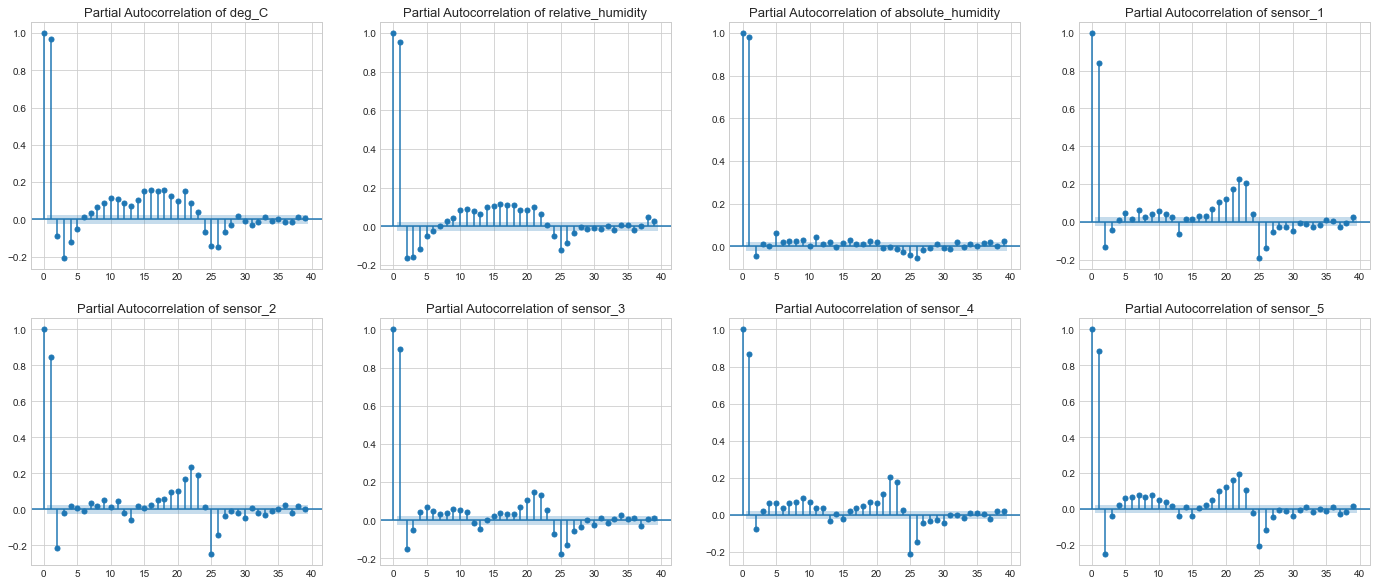

In [56]:
# Partial Autocorrelation of all features
fig, ax = plt.subplots(2,4,figsize=(24,10))
for i in range(len(train.columns[1:9])):
    #plot_pacf(train.iloc[:, i+1], lags=24, ax=ax[i//4, i%4])
    plot_pacf(train.iloc[:, i+1], ax=ax[i//4, i%4])
    ax[i//4, i%4].set_title(f'Partial Autocorrelation of {train.columns[i+1]}',fontsize=13)
plt.show()

- degC: significant lag values at 1, 3 hours
- relHum: significant lag values at 1 hours
- absHum: significant lag values at 1 hours
- sen1: significant lag values at 1, 22, 23 hours
- sen2: significant lag values at 1, 2, 22, 25 hours
- sen3: significant lag values at 1 hours
- sen4: significant lag values at 1, 22, 25 hours
- sen5: significant lag values at 1, 2, 25 hours

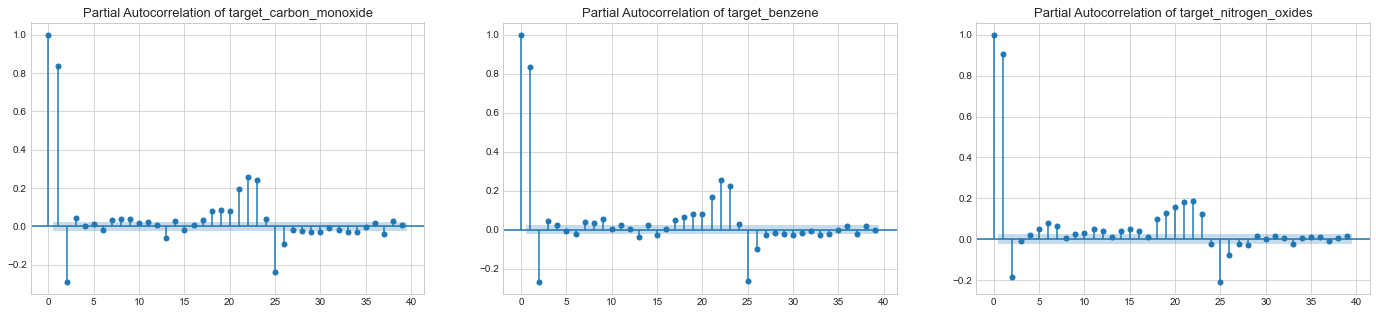

In [57]:
# Partial Autocorrelation of all targets
fig, ax = plt.subplots(1,3,figsize=(24,5))
for i in range(len(train.columns[9:12])):
    #plot_pacf(train.iloc[:, i+9], lags=24, ax=ax[i%3])
    plot_pacf(train.iloc[:, i+9], ax=ax[i%3])
    ax[i%3].set_title(f'Partial Autocorrelation of {train.columns[i+9]}',fontsize=13)
plt.show()

- carbonMonoxide: significant lag values at 1, 2, 22, 23, 25 hours
- benzene: significant lag values at 1, 2, 22, 23, 25 hours
- nitrogenOxides: significant lag values at 1, 25 hours

## Feature Engineering

### Date , Time Features

In [58]:
train['date_time'] = pd.to_datetime(train['date_time'],format='%Y-%m-%d %H:%M')
test['date_time'] = pd.to_datetime(test['date_time'],format='%Y-%m-%d %H:%M')

train['year'] =           train['date_time'].dt.year 
train['month'] =          train['date_time'].dt.month 
train['day'] =            train['date_time'].dt.day
train['hour'] =           train['date_time'].dt.hour
train['dayofweek_num'] =  train['date_time'].dt.dayofweek  

test['year'] =            test['date_time'].dt.year 
test['month'] =           test['date_time'].dt.month 
test['day'] =             test['date_time'].dt.day
test['hour'] =            test['date_time'].dt.hour
test['dayofweek_num'] =   test['date_time'].dt.dayofweek  

### Lag Features
The chosen lag value(s) depend on the correlation of individual values with its past values.

#### Create Lag Features

In [59]:
""" Train Lags (1, 23, 24, 25, 168, 720) """

# Deg C
train['degC-1']    =  train['deg_C'] - train['deg_C'].shift(periods=1)
train['degC-2']    =  train['deg_C'] - train['deg_C'].shift(periods=2)
train['degC-23']   =  train['deg_C'] - train['deg_C'].shift(periods=23)
train['degC-24']   =  train['deg_C'] - train['deg_C'].shift(periods=24)
train['degC-25']   =  train['deg_C'] - train['deg_C'].shift(periods=25)
train['degC-168']  =  train['deg_C'] - train['deg_C'].shift(periods=168)
train['degC-720']  =  train['deg_C'] - train['deg_C'].shift(periods=720)

# Relative Humidity
train['relHum-1']    =  train['relative_humidity'] - train['relative_humidity'].shift(periods=1)
train['relHum-2']    =  train['relative_humidity'] - train['relative_humidity'].shift(periods=2)
train['relHum-23']   =  train['relative_humidity'] - train['relative_humidity'].shift(periods=23)
train['relHum-24']   =  train['relative_humidity'] - train['relative_humidity'].shift(periods=24)
train['relHum-25']   =  train['relative_humidity'] - train['relative_humidity'].shift(periods=25)
train['relHum-168']  =  train['relative_humidity'] - train['relative_humidity'].shift(periods=168)
train['relHum-720']  =  train['relative_humidity'] - train['relative_humidity'].shift(periods=720)

# Absolute Humidity
train['absHum-1']    =  train['absolute_humidity'] - train['absolute_humidity'].shift(periods=1)
train['absHum-2']    =  train['absolute_humidity'] - train['absolute_humidity'].shift(periods=2)
train['absHum-23']   =  train['absolute_humidity'] - train['absolute_humidity'].shift(periods=23)
train['absHum-24']   =  train['absolute_humidity'] - train['absolute_humidity'].shift(periods=24)
train['absHum-25']   =  train['absolute_humidity'] - train['absolute_humidity'].shift(periods=25)
train['absHum-168']  =  train['absolute_humidity'] - train['absolute_humidity'].shift(periods=168)
train['absHum-720']  =  train['absolute_humidity'] - train['absolute_humidity'].shift(periods=720)

# Sensor 1
train['sen1-1']    =  train['sensor_1'] - train['sensor_1'].shift(periods=1)
train['sen1-2']    =  train['sensor_1'] - train['sensor_1'].shift(periods=2)
train['sen1-23']   =  train['sensor_1'] - train['sensor_1'].shift(periods=23)
train['sen1-24']   =  train['sensor_1'] - train['sensor_1'].shift(periods=24)
train['sen1-25']   =  train['sensor_1'] - train['sensor_1'].shift(periods=25)
train['sen1-168']  =  train['sensor_1'] - train['sensor_1'].shift(periods=168)
train['sen1-720']  =  train['sensor_1'] - train['sensor_1'].shift(periods=720)

# Sensor 2
train['sen2-1']    =  train['sensor_2'] - train['sensor_2'].shift(periods=1)
train['sen2-2']    =  train['sensor_2'] - train['sensor_2'].shift(periods=2)
train['sen2-23']   =  train['sensor_2'] - train['sensor_2'].shift(periods=23)
train['sen2-24']   =  train['sensor_2'] - train['sensor_2'].shift(periods=24)
train['sen2-25']   =  train['sensor_2'] - train['sensor_2'].shift(periods=25)
train['sen2-168']  =  train['sensor_2'] - train['sensor_2'].shift(periods=168)
train['sen2-720']  =  train['sensor_2'] - train['sensor_2'].shift(periods=720)

# Sensor 3
train['sen3-1']    =  train['sensor_3'] - train['sensor_3'].shift(periods=1)
train['sen3-2']    =  train['sensor_3'] - train['sensor_3'].shift(periods=2)
train['sen3-23']   =  train['sensor_3'] - train['sensor_3'].shift(periods=23)
train['sen3-24']   =  train['sensor_3'] - train['sensor_3'].shift(periods=24)
train['sen3-25']   =  train['sensor_3'] - train['sensor_3'].shift(periods=25)
train['sen3-168']  =  train['sensor_3'] - train['sensor_3'].shift(periods=168)
train['sen3-720']  =  train['sensor_3'] - train['sensor_3'].shift(periods=720)

# Sensor 4
train['sen4-1']    =  train['sensor_4'] - train['sensor_4'].shift(periods=1)
train['sen4-2']    =  train['sensor_4'] - train['sensor_4'].shift(periods=2)
train['sen4-23']   =  train['sensor_4'] - train['sensor_4'].shift(periods=23)
train['sen4-24']   =  train['sensor_4'] - train['sensor_4'].shift(periods=24)
train['sen4-25']   =  train['sensor_4'] - train['sensor_4'].shift(periods=25)
train['sen4-168']  =  train['sensor_4'] - train['sensor_4'].shift(periods=168)
train['sen4-720']  =  train['sensor_4'] - train['sensor_4'].shift(periods=720)

# Sensor 5
train['sen5-1']    =  train['sensor_5'] - train['sensor_5'].shift(periods=1)
train['sen5-2']    =  train['sensor_5'] - train['sensor_5'].shift(periods=2)
train['sen5-23']   =  train['sensor_5'] - train['sensor_5'].shift(periods=23)
train['sen5-24']   =  train['sensor_5'] - train['sensor_5'].shift(periods=24)
train['sen5-25']   =  train['sensor_5'] - train['sensor_5'].shift(periods=25)
train['sen5-168']  =  train['sensor_5'] - train['sensor_5'].shift(periods=168)
train['sen5-720']  =  train['sensor_5'] - train['sensor_5'].shift(periods=720)


""" Test Lags (1, 23, 24, 25, 168, 720) """

# Deg C
test['degC-1']    =  test['deg_C'] - test['deg_C'].shift(periods=1)
test['degC-2']    =  test['deg_C'] - test['deg_C'].shift(periods=2)
test['degC-23']   =  test['deg_C'] - test['deg_C'].shift(periods=23)
test['degC-24']   =  test['deg_C'] - test['deg_C'].shift(periods=24)
test['degC-25']   =  test['deg_C'] - test['deg_C'].shift(periods=25)
test['degC-168']  =  test['deg_C'] - test['deg_C'].shift(periods=168)
test['degC-720']  =  test['deg_C'] - test['deg_C'].shift(periods=720)

# Relative Humidity
test['relHum-1']    =  test['relative_humidity'] - test['relative_humidity'].shift(periods=1)
test['relHum-2']    =  test['relative_humidity'] - test['relative_humidity'].shift(periods=2)
test['relHum-23']   =  test['relative_humidity'] - test['relative_humidity'].shift(periods=23)
test['relHum-24']   =  test['relative_humidity'] - test['relative_humidity'].shift(periods=24)
test['relHum-25']   =  test['relative_humidity'] - test['relative_humidity'].shift(periods=25)
test['relHum-168']  =  test['relative_humidity'] - test['relative_humidity'].shift(periods=168)
test['relHum-720']  =  test['relative_humidity'] - test['relative_humidity'].shift(periods=720)

# Absolute Humidity
test['absHum-1']    =  test['absolute_humidity'] - test['absolute_humidity'].shift(periods=1)
test['absHum-2']    =  test['absolute_humidity'] - test['absolute_humidity'].shift(periods=2)
test['absHum-23']   =  test['absolute_humidity'] - test['absolute_humidity'].shift(periods=23)
test['absHum-24']   =  test['absolute_humidity'] - test['absolute_humidity'].shift(periods=24)
test['absHum-25']   =  test['absolute_humidity'] - test['absolute_humidity'].shift(periods=25)
test['absHum-168']  =  test['absolute_humidity'] - test['absolute_humidity'].shift(periods=168)
test['absHum-720']  =  test['absolute_humidity'] - test['absolute_humidity'].shift(periods=720)

# Sensor 1
test['sen1-1']    =  test['sensor_1'] - test['sensor_1'].shift(periods=1)
test['sen1-2']    =  test['sensor_1'] - test['sensor_1'].shift(periods=2)
test['sen1-23']   =  test['sensor_1'] - test['sensor_1'].shift(periods=23)
test['sen1-24']   =  test['sensor_1'] - test['sensor_1'].shift(periods=24)
test['sen1-25']   =  test['sensor_1'] - test['sensor_1'].shift(periods=25)
test['sen1-168']  =  test['sensor_1'] - test['sensor_1'].shift(periods=168)
test['sen1-720']  =  test['sensor_1'] - test['sensor_1'].shift(periods=720)

# Sensor 2
test['sen2-1']    =  test['sensor_2'] - test['sensor_2'].shift(periods=1)
test['sen2-2']    =  test['sensor_2'] - test['sensor_2'].shift(periods=2)
test['sen2-23']   =  test['sensor_2'] - test['sensor_2'].shift(periods=23)
test['sen2-24']   =  test['sensor_2'] - test['sensor_2'].shift(periods=24)
test['sen2-25']   =  test['sensor_2'] - test['sensor_2'].shift(periods=25)
test['sen2-168']  =  test['sensor_2'] - test['sensor_2'].shift(periods=168)
test['sen2-720']  =  test['sensor_2'] - test['sensor_2'].shift(periods=720)

# Sensor 3
test['sen3-1']    =  test['sensor_3'] - test['sensor_3'].shift(periods=1)
test['sen3-2']    =  test['sensor_3'] - test['sensor_3'].shift(periods=2)
test['sen3-23']   =  test['sensor_3'] - test['sensor_3'].shift(periods=23)
test['sen3-24']   =  test['sensor_3'] - test['sensor_3'].shift(periods=24)
test['sen3-25']   =  test['sensor_3'] - test['sensor_3'].shift(periods=25)
test['sen3-168']  =  test['sensor_3'] - test['sensor_3'].shift(periods=168)
test['sen3-720']  =  test['sensor_3'] - test['sensor_3'].shift(periods=720)

# Sensor 4
test['sen4-1']    =  test['sensor_4'] - test['sensor_4'].shift(periods=1)
test['sen4-2']    =  test['sensor_4'] - test['sensor_4'].shift(periods=2)
test['sen4-23']   =  test['sensor_4'] - test['sensor_4'].shift(periods=23)
test['sen4-24']   =  test['sensor_4'] - test['sensor_4'].shift(periods=24)
test['sen4-25']   =  test['sensor_4'] - test['sensor_4'].shift(periods=25)
test['sen4-168']  =  test['sensor_4'] - test['sensor_4'].shift(periods=168)
test['sen4-720']  =  test['sensor_4'] - test['sensor_4'].shift(periods=720)

# Sensor 5
test['sen5-1']    =  test['sensor_5'] - test['sensor_5'].shift(periods=1)
test['sen5-2']    =  test['sensor_5'] - test['sensor_5'].shift(periods=2)
test['sen5-23']   =  test['sensor_5'] - test['sensor_5'].shift(periods=23)
test['sen5-24']   =  test['sensor_5'] - test['sensor_5'].shift(periods=24)
test['sen5-25']   =  test['sensor_5'] - test['sensor_5'].shift(periods=25)
test['sen5-168']  =  test['sensor_5'] - test['sensor_5'].shift(periods=168)
test['sen5-720']  =  test['sensor_5'] - test['sensor_5'].shift(periods=720)

#### Fill NaNs in Lag Features

In [60]:
""" TRAIN """
# Deg C
train['degC-1'][0:1]      =  train['deg_C'][0:1]
train['degC-2'][0:2]      =  train['deg_C'][0:2]
train['degC-23'][0:23]    =  train['deg_C'][0:23]
train['degC-24'][0:24]    =  train['deg_C'][0:24]
train['degC-25'][0:25]    =  train['deg_C'][0:25]
train['degC-168'][0:168]  =  train['deg_C'][0:168]
train['degC-720'][0:720]  =  train['deg_C'][0:720]

# Relative Humidity
train['relHum-1'][0:1]      =  train['relative_humidity'][0:1]
train['relHum-2'][0:2]      =  train['relative_humidity'][0:2]
train['relHum-23'][0:23]    =  train['relative_humidity'][0:23]
train['relHum-24'][0:24]    =  train['relative_humidity'][0:24]
train['relHum-25'][0:25]    =  train['relative_humidity'][0:25]
train['relHum-168'][0:168]  =  train['relative_humidity'][0:168]
train['relHum-720'][0:720]  =  train['relative_humidity'][0:720]

# Absolute Humidity
train['absHum-1'][0:1]      =  train['absolute_humidity'][0:1]
train['absHum-2'][0:2]      =  train['absolute_humidity'][0:2]
train['absHum-23'][0:23]    =  train['absolute_humidity'][0:23]
train['absHum-24'][0:24]    =  train['absolute_humidity'][0:24]
train['absHum-25'][0:25]    =  train['absolute_humidity'][0:25]
train['absHum-168'][0:168]  =  train['absolute_humidity'][0:168]
train['absHum-720'][0:720]  =  train['absolute_humidity'][0:720]

# Sensor 1
train['sen1-1'][0:1]      =  train['sensor_1'][0:1]
train['sen1-2'][0:2]      =  train['sensor_1'][0:2]
train['sen1-23'][0:23]    =  train['sensor_1'][0:23]
train['sen1-24'][0:24]    =  train['sensor_1'][0:24]
train['sen1-25'][0:25]    =  train['sensor_1'][0:25]
train['sen1-168'][0:168]  =  train['sensor_1'][0:168]
train['sen1-720'][0:720]  =  train['sensor_1'][0:720]

# Sensor 2
train['sen2-1'][0:1]      =  train['sensor_2'][0:1]
train['sen2-2'][0:2]      =  train['sensor_2'][0:2]
train['sen2-23'][0:23]    =  train['sensor_2'][0:23]
train['sen2-24'][0:24]    =  train['sensor_2'][0:24]
train['sen2-25'][0:25]    =  train['sensor_2'][0:25]
train['sen2-168'][0:168]  =  train['sensor_2'][0:168]
train['sen2-720'][0:720]  =  train['sensor_2'][0:720]

# Sensor 3
train['sen3-1'][0:1]      =  train['sensor_3'][0:1]
train['sen3-2'][0:2]      =  train['sensor_3'][0:2]
train['sen3-23'][0:23]    =  train['sensor_3'][0:23]
train['sen3-24'][0:24]    =  train['sensor_3'][0:24]
train['sen3-25'][0:25]    =  train['sensor_3'][0:25]
train['sen3-168'][0:168]  =  train['sensor_3'][0:168]
train['sen3-720'][0:720]  =  train['sensor_3'][0:720]

# Sensor 4
train['sen4-1'][0:1]      =  train['sensor_4'][0:1]
train['sen4-2'][0:2]      =  train['sensor_4'][0:2]
train['sen4-23'][0:23]    =  train['sensor_4'][0:23]
train['sen4-24'][0:24]    =  train['sensor_4'][0:24]
train['sen4-25'][0:25]    =  train['sensor_4'][0:25]
train['sen4-168'][0:168]  =  train['sensor_4'][0:168]
train['sen4-720'][0:720]  =  train['sensor_4'][0:720]

# Sensor 5
train['sen5-1'][0:1]      =  train['sensor_5'][0:1]
train['sen5-2'][0:2]      =  train['sensor_5'][0:2]
train['sen5-23'][0:23]    =  train['sensor_5'][0:23]
train['sen5-24'][0:24]    =  train['sensor_5'][0:24]
train['sen5-25'][0:25]    =  train['sensor_5'][0:25]
train['sen5-168'][0:168]  =  train['sensor_5'][0:168]
train['sen5-720'][0:720]  =  train['sensor_5'][0:720]


""" TEST """
# Deg C
test['degC-1'][0:1]      =  test['deg_C'][0:1]
test['degC-2'][0:2]      =  test['deg_C'][0:2]
test['degC-23'][0:23]    =  test['deg_C'][0:23]
test['degC-24'][0:24]    =  test['deg_C'][0:24]
test['degC-25'][0:25]    =  test['deg_C'][0:25]
test['degC-168'][0:168]  =  test['deg_C'][0:168]
test['degC-720'][0:720]  =  test['deg_C'][0:720]

# Relative Humidity
test['relHum-1'][0:1]      =  test['relative_humidity'][0:1]
test['relHum-2'][0:2]      =  test['relative_humidity'][0:2]
test['relHum-23'][0:23]    =  test['relative_humidity'][0:23]
test['relHum-24'][0:24]    =  test['relative_humidity'][0:24]
test['relHum-25'][0:25]    =  test['relative_humidity'][0:25]
test['relHum-168'][0:168]  =  test['relative_humidity'][0:168]
test['relHum-720'][0:720]  =  test['relative_humidity'][0:720]

# Absolute Humidity
test['absHum-1'][0:1]      =  test['absolute_humidity'][0:1]
test['absHum-2'][0:2]      =  test['absolute_humidity'][0:2]
test['absHum-23'][0:23]    =  test['absolute_humidity'][0:23]
test['absHum-24'][0:24]    =  test['absolute_humidity'][0:24]
test['absHum-25'][0:25]    =  test['absolute_humidity'][0:25]
test['absHum-168'][0:168]  =  test['absolute_humidity'][0:168]
test['absHum-720'][0:720]  =  test['absolute_humidity'][0:720]

# Sensor 1
test['sen1-1'][0:1]      =  test['sensor_1'][0:1]
test['sen1-2'][0:2]      =  test['sensor_1'][0:2]
test['sen1-23'][0:23]    =  test['sensor_1'][0:23]
test['sen1-24'][0:24]    =  test['sensor_1'][0:24]
test['sen1-25'][0:25]    =  test['sensor_1'][0:25]
test['sen1-168'][0:168]  =  test['sensor_1'][0:168]
test['sen1-720'][0:720]  =  test['sensor_1'][0:720]

# Sensor 2
test['sen2-1'][0:1]      =  test['sensor_2'][0:1]
test['sen2-2'][0:2]      =  test['sensor_2'][0:2]
test['sen2-23'][0:23]    =  test['sensor_2'][0:23]
test['sen2-24'][0:24]    =  test['sensor_2'][0:24]
test['sen2-25'][0:25]    =  test['sensor_2'][0:25]
test['sen2-168'][0:168]  =  test['sensor_2'][0:168]
test['sen2-720'][0:720]  =  test['sensor_2'][0:720]

# Sensor 3
test['sen3-1'][0:1]      =  test['sensor_3'][0:1]
test['sen3-2'][0:2]      =  test['sensor_3'][0:2]
test['sen3-23'][0:23]    =  test['sensor_3'][0:23]
test['sen3-24'][0:24]    =  test['sensor_3'][0:24]
test['sen3-25'][0:25]    =  test['sensor_3'][0:25]
test['sen3-168'][0:168]  =  test['sensor_3'][0:168]
test['sen3-720'][0:720]  =  test['sensor_3'][0:720]

# Sensor 4
test['sen4-1'][0:1]      =  test['sensor_4'][0:1]
test['sen4-2'][0:2]      =  test['sensor_4'][0:2]
test['sen4-23'][0:23]    =  test['sensor_4'][0:23]
test['sen4-24'][0:24]    =  test['sensor_4'][0:24]
test['sen4-25'][0:25]    =  test['sensor_4'][0:25]
test['sen4-168'][0:168]  =  test['sensor_4'][0:168]
test['sen4-720'][0:720]  =  test['sensor_4'][0:720]

# Sensor 5
test['sen5-1'][0:1]      =  test['sensor_5'][0:1]
test['sen5-2'][0:2]      =  test['sensor_5'][0:2]
test['sen5-23'][0:23]    =  test['sensor_5'][0:23]
test['sen5-24'][0:24]    =  test['sensor_5'][0:24]
test['sen5-25'][0:25]    =  test['sensor_5'][0:25]
test['sen5-168'][0:168]  =  test['sensor_5'][0:168]
test['sen5-720'][0:720]  =  test['sensor_5'][0:720]

In [61]:
# Drop date_time column
train.drop(['date_time'], axis=1, inplace=True)
test.drop(['date_time'], axis=1, inplace=True)

In [62]:
train.shape, test.shape

((7111, 72), (2247, 69))

### Mutual Information

In [63]:
discrete_features = X.dtypes == int

In [64]:
# Function to create mutual information scores
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [65]:
# Function to plot mutual information scores
def plot_mi_scores(scores, target_name, plot_color):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores, color=plot_color)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores" + " " + str(target_name))

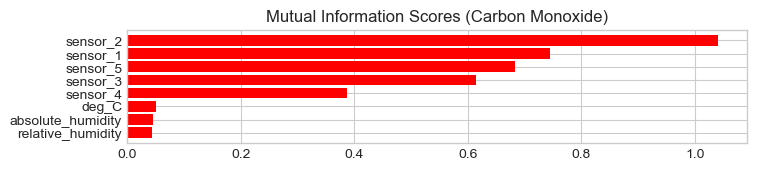

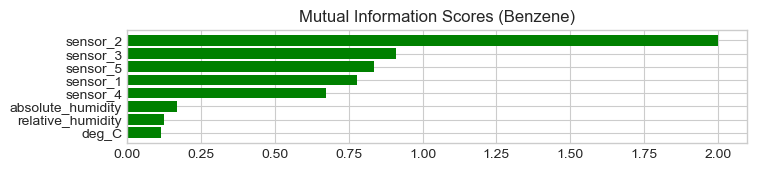

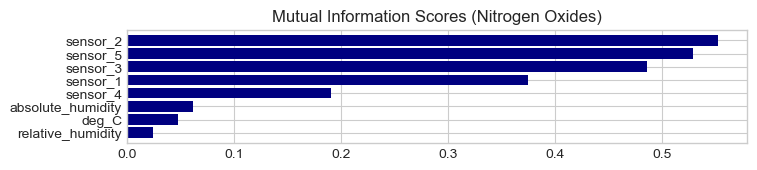

In [66]:
# Carbon Monoxide
mi_scores = make_mi_scores(X, y[['target_carbon_monoxide']], discrete_features)
plt.figure(dpi=100, figsize=(8, 1.5))
plot_mi_scores(mi_scores, '(Carbon Monoxide)', 'red')

# Benzene
mi_scores = make_mi_scores(X, y[['target_benzene']], discrete_features)
plt.figure(dpi=100, figsize=(8, 1.5))
plot_mi_scores(mi_scores, '(Benzene)', 'green')

# Nitrogen Oxides
mi_scores = make_mi_scores(X, y[['target_nitrogen_oxides']], discrete_features)
plt.figure(dpi=100, figsize=(8, 1.5))
plot_mi_scores(mi_scores, '(Nitrogen Oxides)', 'navy')

### Visualize Data

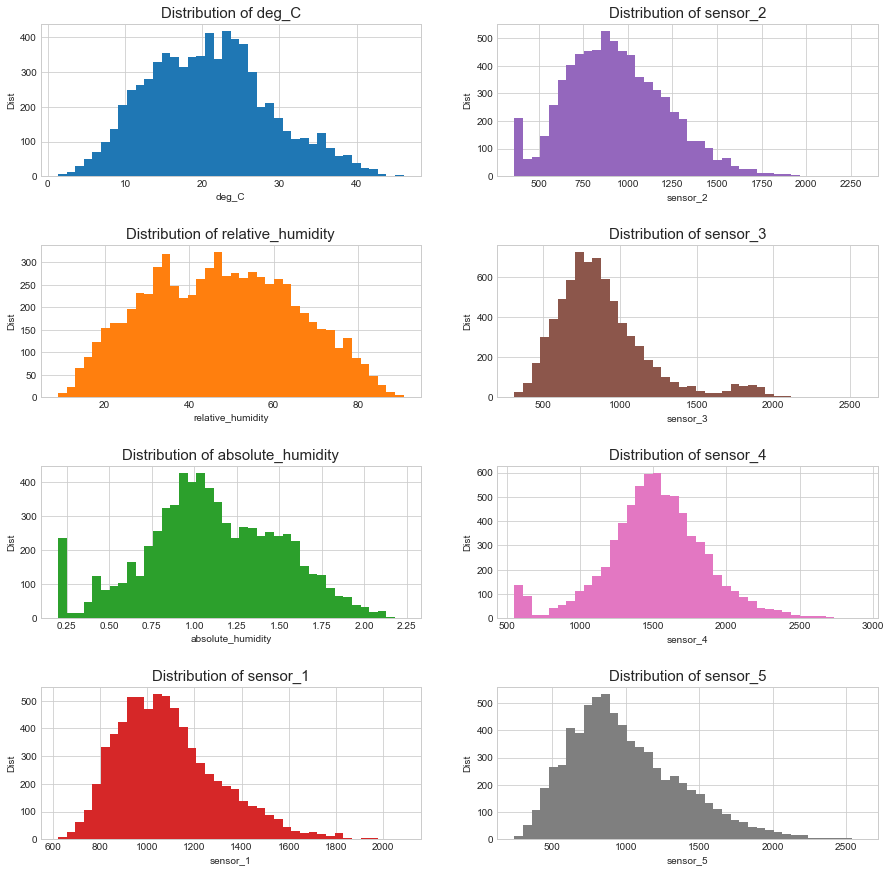

In [67]:
# Plot distributions of features
fig, ax = plt.subplots(4, 2, figsize=(15, 15))
for i in range(len(X.columns)):
    ax[i%4, i//4].hist(X.iloc[:, i],bins=40,color=color_palette[i])
    ax[i%4, i//4].set_title(f'Distribution of {X.columns[i]}',fontsize=15)
    ax[i%4, i//4].set_xlabel(f'{X.columns[i]}')
    ax[i%4, i//4].set_ylabel('Dist')
    plt.subplots_adjust(hspace=0.45)

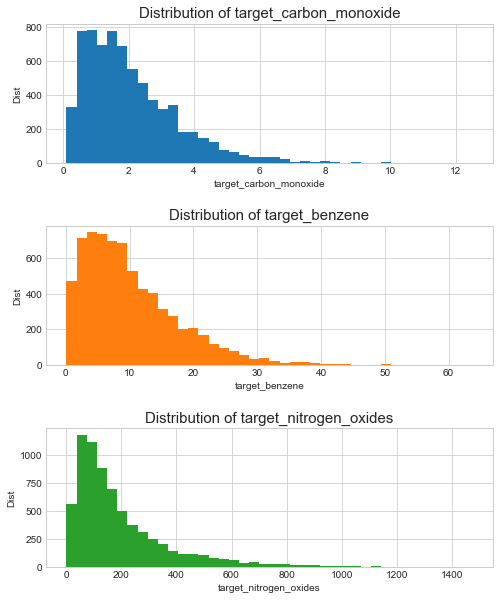

In [68]:
# Plot distributions of targets
fig, ax = plt.subplots(3, 1, figsize=(8, 10))
for i in range(len(y.columns)):
    ax[i%3].hist(y.iloc[:, i],bins=40,color=color_palette[i])
    ax[i%3].set_title(f'Distribution of {y.columns[i]}',fontsize=15)
    ax[i%3].set_xlabel(f'{y.columns[i]}')
    ax[i%3].set_ylabel('Dist')
    plt.subplots_adjust(hspace=0.45)

### Feature Scaling

In [69]:
# Data (Lagged)
X = train[['deg_C', 'relative_humidity', 'absolute_humidity',
           'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5',
           'year', 'month', 'day', 'hour', 'dayofweek_num',
           'degC-1', 'degC-2', 'degC-23', 'degC-24', 'degC-25', 'degC-168', 'degC-720',
           'relHum-1', 'relHum-2', 'relHum-23', 'relHum-24', 'relHum-25', 'relHum-168', 'relHum-720',
           'absHum-1', 'absHum-2', 'absHum-23', 'absHum-24', 'absHum-25', 'absHum-168', 'absHum-720',
           'sen1-1', 'sen1-2', 'sen1-23', 'sen1-24', 'sen1-25', 'sen1-168', 'sen1-720',
           'sen2-1', 'sen2-2', 'sen2-23', 'sen2-24', 'sen2-25', 'sen2-168', 'sen2-720',
           'sen3-1', 'sen3-2', 'sen3-23', 'sen3-24', 'sen3-25', 'sen3-168', 'sen3-720',
           'sen4-1', 'sen4-2', 'sen4-23', 'sen4-24', 'sen4-25', 'sen4-168', 'sen4-720',
           'sen5-1', 'sen5-2', 'sen5-23', 'sen5-24', 'sen5-25', 'sen5-168', 'sen5-720']]

y = train[['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides']]

test = test[['deg_C', 'relative_humidity', 'absolute_humidity',
             'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5',
             'year', 'month', 'day', 'hour', 'dayofweek_num',
             'degC-1', 'degC-2', 'degC-23', 'degC-24', 'degC-25', 'degC-168', 'degC-720',
             'relHum-1', 'relHum-2', 'relHum-23', 'relHum-24', 'relHum-25', 'relHum-168', 'relHum-720',
             'absHum-1', 'absHum-2', 'absHum-23', 'absHum-24', 'absHum-25', 'absHum-168', 'absHum-720',
             'sen1-1', 'sen1-2', 'sen1-23', 'sen1-24', 'sen1-25', 'sen1-168', 'sen1-720',
             'sen2-1', 'sen2-2', 'sen2-23', 'sen2-24', 'sen2-25', 'sen2-168', 'sen2-720',
             'sen3-1', 'sen3-2', 'sen3-23', 'sen3-24', 'sen3-25', 'sen3-168', 'sen3-720',
             'sen4-1', 'sen4-2', 'sen4-23', 'sen4-24', 'sen4-25', 'sen4-168', 'sen4-720',
             'sen5-1', 'sen5-2', 'sen5-23', 'sen5-24', 'sen5-25', 'sen5-168', 'sen5-720']]

In [70]:
# StandardScaler data
sc = StandardScaler()

X_scaled = sc.fit_transform(X)
test_scaled = sc.transform(test) 
y_log = np.log1p(y) # log normalize targets

In [71]:
# Convert back to DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=['deg_C', 'relative_humidity', 'absolute_humidity',
                                           'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5',
                                           'year', 'month', 'day', 'hour', 'dayofweek_num',
                                           'degC-1', 'degC-2', 'degC-23', 'degC-24', 'degC-25', 'degC-168', 'degC-720',
                                           'relHum-1', 'relHum-2', 'relHum-23', 'relHum-24', 'relHum-25', 'relHum-168', 'relHum-720',
                                           'absHum-1', 'absHum-2', 'absHum-23', 'absHum-24', 'absHum-25', 'absHum-168', 'absHum-720',
                                           'sen1-1', 'sen1-2', 'sen1-23', 'sen1-24', 'sen1-25', 'sen1-168', 'sen1-720',
                                           'sen2-1', 'sen2-2', 'sen2-23', 'sen2-24', 'sen2-25', 'sen2-168', 'sen2-720',
                                           'sen3-1', 'sen3-2', 'sen3-23', 'sen3-24', 'sen3-25', 'sen3-168', 'sen3-720',
                                           'sen4-1', 'sen4-2', 'sen4-23', 'sen4-24', 'sen4-25', 'sen4-168', 'sen4-720',
                                           'sen5-1', 'sen5-2', 'sen5-23', 'sen5-24', 'sen5-25', 'sen5-168', 'sen5-720'])

test_scaled = pd.DataFrame(test_scaled, columns=['deg_C', 'relative_humidity', 'absolute_humidity',
                                                 'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5',
                                                 'year', 'month', 'day', 'hour', 'dayofweek_num',
                                                 'degC-1', 'degC-2', 'degC-23', 'degC-24', 'degC-25', 'degC-168', 'degC-720',
                                                 'relHum-1', 'relHum-2', 'relHum-23', 'relHum-24', 'relHum-25', 'relHum-168', 'relHum-720',
                                                 'absHum-1', 'absHum-2', 'absHum-23', 'absHum-24', 'absHum-25', 'absHum-168', 'absHum-720',
                                                 'sen1-1', 'sen1-2', 'sen1-23', 'sen1-24', 'sen1-25', 'sen1-168', 'sen1-720',
                                                 'sen2-1', 'sen2-2', 'sen2-23', 'sen2-24', 'sen2-25', 'sen2-168', 'sen2-720',
                                                 'sen3-1', 'sen3-2', 'sen3-23', 'sen3-24', 'sen3-25', 'sen3-168', 'sen3-720',
                                                 'sen4-1', 'sen4-2', 'sen4-23', 'sen4-24', 'sen4-25', 'sen4-168', 'sen4-720',
                                                 'sen5-1', 'sen5-2', 'sen5-23', 'sen5-24', 'sen5-25', 'sen5-168', 'sen5-720'])

y_log = pd.DataFrame(y_log, columns=['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides'])

### Validation Set

In [72]:
# Split training data in to training (80%) and validation (20%) data for hyperparameter tuning
from sklearn.model_selection import train_test_split
# Split training data in to training (80%) and validation (20%) data for hyperparameter tuning
X_scaled, X_val, y_log, y_val = train_test_split(X_scaled, y_log, test_size=0.2)
X_scaled.shape, X_val.shape, y_log.shape, y_val.shape

((5688, 69), (1423, 69), (5688, 3), (1423, 3))

In [73]:
y_log_c = y_log['target_carbon_monoxide']
y_log_b = y_log['target_benzene']
y_log_n = y_log['target_nitrogen_oxides']

## Create Baseline Model

In [74]:
from catboost import CatBoostRegressor

# Parameter dictionary
params = {'num_leaves': 100,
          'min_child_samples': 20,
          'learning_rate': 0.1,
          'max_depth': 8,
          'max_bin': 50,
          'grow_policy': 'Lossguide',
          'metric_period': 1000}

model1 = CatBoostRegressor(**params).fit(X_scaled, y_log_c)
model2 = CatBoostRegressor(**params).fit(X_scaled, y_log_b)
model3 = CatBoostRegressor(**params).fit(X_scaled, y_log_n)

0:	learn: 0.3973902	total: 68.4ms	remaining: 1m 8s
999:	learn: 0.0002492	total: 9.8s	remaining: 0us
0:	learn: 0.6922135	total: 14.3ms	remaining: 14.3s
999:	learn: 0.0002415	total: 8.57s	remaining: 0us
0:	learn: 0.8145926	total: 11.1ms	remaining: 11.1s
999:	learn: 0.0005328	total: 9.64s	remaining: 0us


### Predict upon Validation Set and Compute Mean Squared Log Error

In [75]:
y_pred1 = model1.predict(X_val)
y_pred2 = model2.predict(X_val)
y_pred3 = model3.predict(X_val)

# Handle negatives
y_pred1 = [0 if i < 0 else i for i in y_pred1]
y_pred2 = [0 if i < 0 else i for i in y_pred2]
y_pred3 = [0 if i < 0 else i for i in y_pred3]

# Invert normalized predictions
y_pred1 = np.expm1(y_pred1)
y_pred2 = np.expm1(y_pred2)
y_pred3 = np.expm1(y_pred3)

In [76]:
baseline_rmsle1 = round(np.sqrt(mean_squared_log_error(y_val[y_val.columns[0]], y_pred1)), 4)
baseline_rmsle2 = round(np.sqrt(mean_squared_log_error(y_val[y_val.columns[1]], y_pred2)), 4)
baseline_rmsle3 = round(np.sqrt(mean_squared_log_error(y_val[y_val.columns[2]], y_pred3)), 4)
total_rmsle = round(baseline_rmsle1+baseline_rmsle2+baseline_rmsle3, 4)

print('RMSLE ({}): {}'.format('target_carbon_monoxide', baseline_rmsle1))
print('RMSLE ({}): {}'.format('target_benzene', baseline_rmsle2))
print('RMSLE ({}): {}'.format('target_nitrogen_oxides', baseline_rmsle3))
print('Total RMSLE: {}'.format(total_rmsle))

RMSLE (target_carbon_monoxide): 0.4049
RMSLE (target_benzene): 1.1521
RMSLE (target_nitrogen_oxides): 3.2474
Total RMSLE: 4.8044


## Hyperparameter Tune Model

In [77]:
def tune_catboostregressor(X_train, X_val, y_train, y_val, num_leaves_vals, min_child_samples_vals, learning_rate_vals, max_depth_vals, max_bin_vals, weights=None, verbose=False, metric_period=10000):
    
    # Create empty lists where we will store the results of hyperparameter tuning 
    parameters = []
    models = []
    val_scores = [] # validation root mean square log errors
    
    # Loop through the hyperparameters of interest
    for num_leaves in num_leaves_vals:
        for min_child_samples in min_child_samples_vals:
            for learning_rate in learning_rate_vals:
                for max_depth in max_depth_vals:
                    for max_bin in max_bin_vals:
                    
                        # Train the CatBoostRegressor model with the given hyperparameters
                        catboost = CatBoostRegressor(num_leaves=num_leaves, min_child_samples=min_child_samples,
                                                     learning_rate=learning_rate, max_depth=max_depth,
                                                     max_bin=max_bin, grow_policy='Lossguide',metric_period=1000)

                        # Fit the model using the training data
                        catboost = catboost.fit(X_train, y_train)

                        # Predict upon validation
                        y_pred = catboost.predict(X_val)
                        y_pred = [0 if i < 0 else i for i in y_pred] # convert negative predictions to 0

                        # Get the evalution metric on the validation set 
                        score = np.sqrt(mean_squared_log_error(y_val, y_pred))

                        # Store the results
                        parameters.append({'num_leaves': num_leaves, 'min_child_samples': min_child_samples, 
                                           'learning_rate': learning_rate, 'max_depth': max_depth,
                                           'max_bin': max_bin, 'grow_policy':'Lossguide'})
                        models.append(catboost)
                        val_scores.append(score)

                        # Print the results
                        if verbose:
                            print('\nParmeters: \tnum_leaves={} \tmin_child_samples={} \tlearning_rate={} \tmax_depth={} \tmax_bin={} \tgrow_policy={}'.format(num_leaves, min_child_samples, learning_rate, max_depth, max_bin, 'Lossguide'))
                            print("Validtion RMSLE: {}".format(score))
                
    # Determine the best model -- that is, the one with the lowest root mean squared error
    best_model_index = np.argmin(val_scores)
    best_model = models[best_model_index]
    
    print("\nBest model parameters: ", parameters[best_model_index])
    print("Best model RSMLE: ", val_scores[best_model_index])
    
    # Return best model
    return best_model, parameters, models, val_scores

In [78]:
# TARGET CARBON MONOXIDE (CatBoost)
"""best_xgb, parameters, models, val_scores = tune_catboostregressor(X_scaled, X_val, y_log_c, y_val[y_val.columns[0]], 
                                                                  num_leaves_vals=[100, 400],
                                                                  min_child_samples_vals=[5, 20],
                                                                  learning_rate_vals=[0.01, 0.1],
                                                                  max_depth_vals=[5, 15],
                                                                  max_bin_vals=[10, 50])"""

'best_xgb, parameters, models, val_scores = tune_catboostregressor(X_scaled, X_val, y_log_c, y_val[y_val.columns[0]], \n                                                                  num_leaves_vals=[100, 400],\n                                                                  min_child_samples_vals=[5, 20],\n                                                                  learning_rate_vals=[0.01, 0.1],\n                                                                  max_depth_vals=[5, 15],\n                                                                  max_bin_vals=[10, 50])'

In [79]:
# TARGET BENZENE (CatBoost)
"""best_xgb, parameters, models, val_scores = tune_catboostregressor(X_scaled, X_val, y_log_b, y_val[y_val.columns[1]], 
                                                                  num_leaves_vals=[100, 400],
                                                                  min_child_samples_vals=[5, 20],
                                                                  learning_rate_vals=[0.01, 0.1],
                                                                  max_depth_vals=[5, 15],
                                                                  max_bin_vals=[10, 50])"""

'best_xgb, parameters, models, val_scores = tune_catboostregressor(X_scaled, X_val, y_log_b, y_val[y_val.columns[1]], \n                                                                  num_leaves_vals=[100, 400],\n                                                                  min_child_samples_vals=[5, 20],\n                                                                  learning_rate_vals=[0.01, 0.1],\n                                                                  max_depth_vals=[5, 15],\n                                                                  max_bin_vals=[10, 50])'

In [80]:
# TARGET NITRON OXIDE (CatBoost)
"""best_xgb, parameters, models, val_scores = tune_catboostregressor(X_scaled, X_val, y_log_n, y_val[y_val.columns[2]], 
                                                                  num_leaves_vals=[100, 400],
                                                                  min_child_samples_vals=[5, 20],
                                                                  learning_rate_vals=[0.01, 0.1],
                                                                  max_depth_vals=[5, 15],
                                                                  max_bin_vals=[10, 50])"""

'best_xgb, parameters, models, val_scores = tune_catboostregressor(X_scaled, X_val, y_log_n, y_val[y_val.columns[2]], \n                                                                  num_leaves_vals=[100, 400],\n                                                                  min_child_samples_vals=[5, 20],\n                                                                  learning_rate_vals=[0.01, 0.1],\n                                                                  max_depth_vals=[5, 15],\n                                                                  max_bin_vals=[10, 50])'

### Train and Fit Best Models for each Target

In [81]:
model1 = CatBoostRegressor(num_leaves=400, min_child_samples=20, learning_rate=0.01, max_depth=15, max_bin=10, grow_policy='Lossguide',  metric_period=1000)
model1.fit(X_scaled, y_log_c)

model2 = CatBoostRegressor(num_leaves=400, min_child_samples=20, learning_rate=0.01, max_depth=15, max_bin=50, grow_policy='Lossguide', metric_period=1000)
model2.fit(X_scaled, y_log_b)

model3 = CatBoostRegressor(num_leaves=400, min_child_samples=20, learning_rate=0.1, max_depth=15, max_bin=50, grow_policy='Lossguide', metric_period=1000)
model3.fit(X_scaled, y_log_n)

0:	learn: 0.4275347	total: 33.8ms	remaining: 33.7s
999:	learn: 0.0214938	total: 25.2s	remaining: 0us
0:	learn: 0.7526915	total: 35.3ms	remaining: 35.3s
999:	learn: 0.0193797	total: 32.6s	remaining: 0us
0:	learn: 0.8202867	total: 34.6ms	remaining: 34.5s
999:	learn: 0.0000000	total: 25.2s	remaining: 0us


### Predict Upon Test Set

In [82]:
# Predict
pred_carbon = model1.predict(test_scaled)
pred_benzene = model2.predict(test_scaled)
pred_nitrogen = model3.predict(test_scaled)

# Invert normalized predictions
pred_carbon = np.expm1(pred_carbon)
pred_benzene = np.expm1(pred_benzene)
pred_nitrogen = np.expm1(pred_nitrogen)

### Create Final CSV

In [83]:
submission = pd.read_csv('sample_submission.csv')
submission['target_carbon_monoxide'] = pred_carbon
submission['target_benzene'] = pred_benzene
submission['target_nitrogen_oxides'] = pred_nitrogen
submission.to_csv('submission.csv', index=False)

In [84]:
submission

,date_time,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2011-01-01 00:00:00,1.358367,5.452986,106.314584
1,2011-01-01 01:00:00,1.866544,8.571497,119.707391
2,2011-01-01 02:00:00,1.709212,7.892440,125.688194
3,2011-01-01 03:00:00,2.045339,8.618508,132.289658
4,2011-01-01 04:00:00,1.383013,6.450328,98.325569
...,...,...,...,...
2242,2011-04-04 10:00:00,2.852139,13.082967,244.242949
2243,2011-04-04 11:00:00,2.240614,10.290597,150.254126
2244,2011-04-04 12:00:00,2.300305,12.331642,155.923579
2245,2011-04-04 13:00:00,2.015542,10.455939,132.281583
